In [1]:
!pip install transformers[torch] datasets -q

In [2]:
import requests
from PIL import Image
import torch
from transformers import BlipProcessor, BlipForQuestionAnswering,BlipImageProcessor, AutoProcessor
from transformers import BlipConfig
from datasets import load_dataset
from torch.utils.data import DataLoader
from tqdm.notebook import tqdm

import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display

2024-05-16 13:04:33.888982: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-16 13:04:33.889075: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-16 13:04:34.003799: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Loading data

In [4]:
dataset = load_dataset("flaviagiammarino/path-vqa")

Generating train split:   0%|          | 0/19654 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/6259 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/6719 [00:00<?, ? examples/s]

In [5]:
dataset

DatasetDict({
    train: Dataset({
        features: ['image', 'question', 'answer'],
        num_rows: 19654
    })
    validation: Dataset({
        features: ['image', 'question', 'answer'],
        num_rows: 6259
    })
    test: Dataset({
        features: ['image', 'question', 'answer'],
        num_rows: 6719
    })
})

Question: what are stained here with an immunohistochemical stain for cytokeratin 7?
Answer: bile duct cells and canals of hering


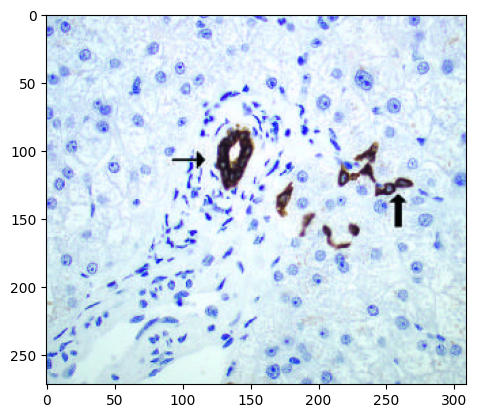

In [6]:
sample = dataset['train'][1]
PIL_image = Image.fromarray(np.array(sample['image'])).convert('RGB')
plt.imshow(sample['image'].convert('RGB'))
print("Question: {}".format(sample['question']))
print("Answer: {}".format(sample['answer']))

In [7]:
config = BlipConfig.from_pretrained("Salesforce/blip-vqa-base")

config.json:   0%|          | 0.00/4.56k [00:00<?, ?B/s]

In [8]:
train_data = dataset['train'].select(range(15000))
val_data = dataset['validation'].select(range(1500))

In [9]:
print(len(train_data['answer']))


15000


In [10]:
class VQADataset(torch.utils.data.Dataset):
    def __init__(self, data, segment, text_processor, image_processor):
        self.data = data
        self.questions = data['question']
        self.answers = data['answer']
        self.text_processor = text_processor
        self.image_processor = image_processor
        self.max_length = 32
        self.image_height = 128
        self.image_width = 128

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        # get image + text
        answers = self.answers[idx]
        questions = self.questions[idx]
        image = self.data[idx]['image'].convert('RGB')
        text = self.questions[idx]

        image_encoding = self.image_processor(image,
                                  do_resize=True,
                                  size=(self.image_height,self.image_width),
                                  return_tensors="pt")

        encoding = self.text_processor(
                                  None,
                                  text,
                                  padding="max_length",
                                  truncation=True,
                                  max_length = self.max_length,
                                  return_tensors="pt"
                                  )
        # # remove batch dimension
        for k,v in encoding.items():
            encoding[k] = v.squeeze()
        encoding["pixel_values"] = image_encoding["pixel_values"][0]
        # # add labels
        labels = self.text_processor.tokenizer.encode(
            answers,
            max_length= self.max_length,
            padding="max_length",
            truncation=True,
            return_tensors='pt'
        )[0]
        encoding["labels"] = labels

        return encoding

In [11]:
text_processor = BlipProcessor.from_pretrained("Salesforce/blip-vqa-base")
image_processor = BlipImageProcessor.from_pretrained("Salesforce/blip-vqa-base")

preprocessor_config.json:   0%|          | 0.00/445 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/592 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/711k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

In [12]:
print(len(text_processor.tokenizer.get_vocab()))

30522


In [13]:
from nltk.tokenize import RegexpTokenizer
from collections import Counter

# Initialize the tokenizer
tokenizer = RegexpTokenizer(r'\w+')

# Initialize the counter
token_counter = Counter()

# Iterate over your dataset
for idx in range(len(val_data)):
    item = val_data[idx]
    # Tokenize the text and update the counter
    token_counter.update(tokenizer.tokenize(item['answer']))
    token_counter.update(tokenizer.tokenize(item['question']))

for idx in range(len(train_data)):
    item = train_data[idx]
    # Tokenize the text and update the counter
    token_counter.update(tokenizer.tokenize(item['answer']))
    token_counter.update(tokenizer.tokenize(item['question']))

# Get the set of tokens in the tokenizer's vocabulary
vocab_tokens = set(text_processor.tokenizer.get_vocab().keys())

# Find the difference between the sets of tokens
unknown_tokens = set(token_counter.keys()) - vocab_tokens

# Add the unknown tokens to the tokenizer
text_processor.tokenizer.add_tokens(list(unknown_tokens))


2016

In [14]:
print(unknown_tokens)
print(len(unknown_tokens))

{'rete', 'pyruvate', 'fragility', 'avium', 'radiolucent', 'contours', 'lewy', 'triploid', 'palpebral', 'arterioles', 'tuberculous', 'germinal', 'intestinal', 'infiltra', 'sinuses', 'intrahepatic', 'dura', 'herniation', 'cherubism', 'intima', 'imperfecta', 'dct', 'protrusion', 'perivascular', 'accuminatum', 'precursors', 'distort', 'predominate', 'subepi', 'stratification', 'diaphragm', 'necrolysis', 'contour', 'thorax', 'combed', 'posterolateral', 'trichrome', 'kupffer', 'ventricle', 'amyloidosis', 'hypereosinophilic', 'shortening', 'b68', 'petechia', 'cemento', 'denatured', 'biliary', 'slipper', 'monosodium', 'bronchopneumonia', 'undermining', 'fibrocollagenous', 'lymphocytic', 'hyperemia', 'staghorn', 'sporotrichosis', 'hilar', 'pituitectomy', 'overload', 'alkaline', 'fibromuscular', 'dentin', 'polarity', 'hilum', 'univacuolated', 'vacuoles', 'acantholysis', 'myxoma', 'colitis', 'panarteritis', 'natomical', 'histiocyte', 'pyelitis', 'retinal', 'corpuscle', 'myeloid', 'lytic', 'blebs'

In [15]:
print(len(text_processor.tokenizer.get_vocab()))

32538


In [16]:
train_vqa_dataset = VQADataset(data=train_data,
                     segment='train',
                     text_processor = text_processor,
                     image_processor = image_processor
                         )

val_vqa_dataset = VQADataset(data=train_data,
                     segment='validation',
                     text_processor = text_processor,
                     image_processor = image_processor
                         )


In [17]:
def collate_fn(batch):
    input_ids = [item['input_ids'] for item in batch]
    pixel_values = [item['pixel_values'] for item in batch]
    attention_mask = [item['attention_mask'] for item in batch]
    labels = [item['labels'] for item in batch]
    # create new batch
    batch = {}
    batch['input_ids'] = torch.stack(input_ids)
    batch['attention_mask'] = torch.stack(attention_mask)
    batch['pixel_values'] = torch.stack(pixel_values)
    batch['labels'] = torch.stack(labels)

    return batch

train_dataloader = DataLoader(train_vqa_dataset,
                              collate_fn=collate_fn,
                              batch_size=64,
                              shuffle=False)
val_dataloader = DataLoader(val_vqa_dataset,
                            collate_fn=collate_fn,
                            batch_size=64,
                            shuffle=False)

In [18]:
batch = next(iter(train_dataloader))
for k,v in batch.items():
    print(k, v.shape)


input_ids torch.Size([64, 32])
attention_mask torch.Size([64, 32])
pixel_values torch.Size([64, 3, 128, 128])
labels torch.Size([64, 32])


#Build Model

In [19]:
model = BlipForQuestionAnswering.from_pretrained("Salesforce/blip-vqa-base" )


model.safetensors:   0%|          | 0.00/1.54G [00:00<?, ?B/s]

In [21]:
import torch
import torch.nn.functional as F

# Get the current embeddings
current_embeddings = model.text_encoder.embeddings.word_embeddings.weight

# Define new vocabulary size
new_vocab_size = len(text_processor.tokenizer)

# Create new embeddings with the same embedding dimension
new_embeddings = torch.nn.Embedding(new_vocab_size, current_embeddings.shape[1])

# Copy the old weights into the new embeddings
with torch.no_grad():
    new_embeddings.weight[:current_embeddings.shape[0]] = current_embeddings
    
    # Initialize new embeddings with a normal distribution and normalize them
    new_embeddings.weight[current_embeddings.shape[0]:] = F.normalize(
        torch.randn(new_vocab_size - current_embeddings.shape[0], current_embeddings.shape[1]),
        dim=1
    )

# Replace the old embeddings with the new embeddings
model.text_encoder.embeddings.word_embeddings = new_embeddings


In [23]:
import torch
import torch.nn.functional as F

# Get the current embeddings
current_embeddings = model.text_decoder.bert.embeddings.word_embeddings.weight

# Define new vocabulary size
new_vocab_size = len(text_processor.tokenizer)

# Create new embeddings with the same embedding dimension
new_embeddings = torch.nn.Embedding(new_vocab_size, current_embeddings.shape[1])

# Copy the old weights into the new embeddings
with torch.no_grad():
    new_embeddings.weight[:current_embeddings.shape[0]] = current_embeddings
    
    # Initialize new embeddings with a normal distribution and normalize them
    new_embeddings.weight[current_embeddings.shape[0]:] = F.normalize(
        torch.randn(new_vocab_size - current_embeddings.shape[0], current_embeddings.shape[1]),
        dim=1
    )

# Replace the old embeddings with the new embeddings
model.text_decoder.bert.embeddings.word_embeddings = new_embeddings



In [25]:
import torch
import torch.nn.functional as F

# Get the current weights
current_weights = model.text_decoder.cls.predictions.decoder.weight

# Define new vocabulary size
new_vocab_size = len(text_processor.tokenizer)

# Create new linear layer
new_linear = torch.nn.Linear(current_weights.shape[1], new_vocab_size)

# Copy the old weights into the new linear layer
with torch.no_grad():
    new_linear.weight.data[:current_weights.shape[0]] = current_weights.data
    
    # Initialize new weights with a normal distribution and normalize them
    new_linear.weight.data[current_weights.shape[0]:] = F.normalize(
        torch.randn(new_vocab_size - current_weights.shape[0], current_weights.shape[1]),
        dim=1
    )

# Replace the old linear layer with the new linear layer
model.text_decoder.cls.predictions.decoder = new_linear

print("Linear layer weights have been successfully extended and initialized with normalization.")


Linear layer weights have been successfully extended and initialized with normalization.


In [26]:
model.config.vocab_size = len(text_processor.tokenizer)

In [27]:
model.text_decoder.config.vocab_size = len(text_processor.tokenizer)

In [28]:
optimizer = torch.optim.AdamW(model.parameters(), lr=5e-5)
image_mean = image_processor.image_mean
image_std = image_processor.image_std

Question:  [CLS] what are stained here with an immunohistochemical stain for cytokeratin 7? [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]
Answer:  [CLS] bile duct cel ls and cana ls of hering [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]


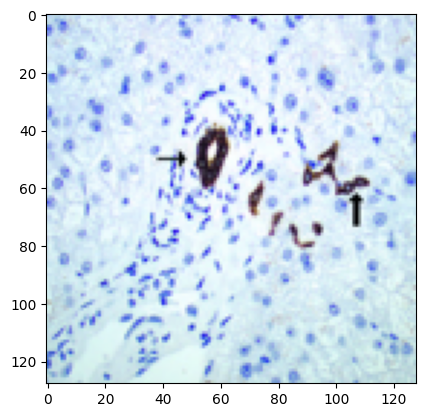

In [29]:
batch_idx = 1

unnormalized_image = (batch["pixel_values"][batch_idx].cpu().numpy() * np.array(image_std)[:, None, None]) + np.array(image_mean)[:, None, None]
unnormalized_image = np.moveaxis(unnormalized_image, 0, -1)
unnormalized_image = (unnormalized_image * 255).astype(np.uint8)

print("Question: ",text_processor.decode(batch["input_ids"][batch_idx]))
print("Answer: ",text_processor.decode(batch["labels"][batch_idx]))
plt.imshow(Image.fromarray(unnormalized_image))

In [30]:
print(model)

BlipForQuestionAnswering(
  (vision_model): BlipVisionModel(
    (embeddings): BlipVisionEmbeddings(
      (patch_embedding): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
    )
    (encoder): BlipEncoder(
      (layers): ModuleList(
        (0-11): 12 x BlipEncoderLayer(
          (self_attn): BlipAttention(
            (dropout): Dropout(p=0.0, inplace=False)
            (qkv): Linear(in_features=768, out_features=2304, bias=True)
            (projection): Linear(in_features=768, out_features=768, bias=True)
          )
          (layer_norm1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
          (mlp): BlipMLP(
            (activation_fn): GELUActivation()
            (fc1): Linear(in_features=768, out_features=3072, bias=True)
            (fc2): Linear(in_features=3072, out_features=768, bias=True)
          )
          (layer_norm2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        )
      )
    )
    (post_layernorm): LayerNorm((768,), eps=1e-05, e

In [31]:
model.to(device)
model.train()
for epoch in range(5):
    print(f"Epoch: {epoch+1}")
    total_loss = []
    for batch in tqdm(train_dataloader):
        # get the inputs;
        batch = {k:v.to(device) for k,v in batch.items()}
        # batch['input_ids'] = batch['input_ids'].view(64, -1)
        # zero the parameter gradients
        optimizer.zero_grad()
        # forward + backward + optimize
        outputs = model(**batch)
        loss = outputs.loss
        total_loss.append(loss.item())
        loss.backward()
        optimizer.step()
    print("Loss:", sum(total_loss))

Epoch: 1


  0%|          | 0/235 [00:00<?, ?it/s]

We strongly recommend passing in an `attention_mask` since your input_ids may be padded. See https://huggingface.co/docs/transformers/troubleshooting#incorrect-output-when-padding-tokens-arent-masked.


Loss: 449.60116912424564
Epoch: 2


  0%|          | 0/235 [00:00<?, ?it/s]

Loss: 70.01439865678549
Epoch: 3


  0%|          | 0/235 [00:00<?, ?it/s]

Loss: 56.92440313845873
Epoch: 4


  0%|          | 0/235 [00:00<?, ?it/s]

Loss: 47.24161006137729
Epoch: 5


  0%|          | 0/235 [00:00<?, ?it/s]

Loss: 40.14339446276426


# Inference

Question:  where are liver stem cel ls ( oval cel ls ) located?


/opt/conda/lib/python3.10/site-packages/transformers/generation/utils.py:1132: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Predicted Answer:  in vasculature
Actual Answer:  in the cana ls of hering


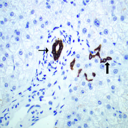

###################################################################
Question:  what are stained here with an immunohistochemical stain for cytokeratin 7?
Predicted Answer:  one
Actual Answer:  bile duct cel ls and cana ls of hering


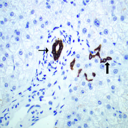

###################################################################
Question:  what do the areas of white chalky deposits represent?
Predicted Answer:  with atherosclerosis and thrombotic occlusion
Actual Answer:  foci of fat necrosis


###################################################################
Question:  is embolus derived from a lower - extremity deep venous thrombus lodged in a pulmonary artery branch?
Predicted Answer:  no
Actual Answer:  yes


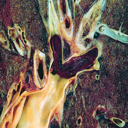

###################################################################
Question:  how is hyperplasia without atypia characterize d?
Predicted Answer:  with fibrosis trichrome
Actual Answer:  by nests of closely packed glands


###################################################################
Question:  is normal palmar creases present?
Predicted Answer:  no
Actual Answer:  no


###################################################################
Question:  where is this from?
Predicted Answer:  no
Actual Answer:  gastrointestinal system


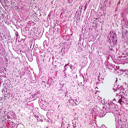

###################################################################
Question:  what is present?
Predicted Answer:  the left ventricle
Actual Answer:  gastrointestinal


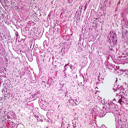

###################################################################
Question:  what is present?
Predicted Answer:  the left ventricle
Actual Answer:  esophagus


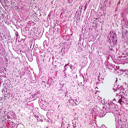

###################################################################
Question:  what is present?
Predicted Answer:  the left ventricle
Actual Answer:  varices


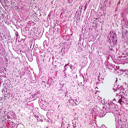

###################################################################
Question:  what does this image show?
Predicted Answer:  with atherosclerosis and thrombotic occlusion
Actual Answer:  excellent photo typical adenocarcinoma extending through muscularis to serosa


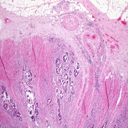

###################################################################
Question:  does this image show excellent photo typical adenocarcinoma extending through muscularis to serosa?
Predicted Answer:  yes
Actual Answer:  yes


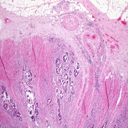

###################################################################
Question:  does typical tuberculous exudate show excellent photo typical adenocarcinoma extending through muscularis to serosa?
Predicted Answer:  no
Actual Answer:  no


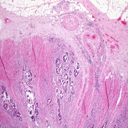

###################################################################
Question:  what is present?
Predicted Answer:  the left ventricle
Actual Answer:  gastrointestinal


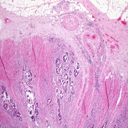

###################################################################
Question:  is gastrointestinal present?
Predicted Answer:  no
Actual Answer:  yes


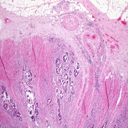

###################################################################
Question:  is hyperplasia without atypia characterize d by nests of closely packed glands?
Predicted Answer:  no
Actual Answer:  yes


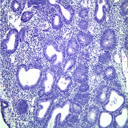

###################################################################
Question:  is mucoepidermoid carcinoma present?
Predicted Answer:  no
Actual Answer:  no


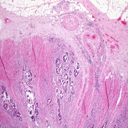

###################################################################
Question:  what is present?
Predicted Answer:  the left ventricle
Actual Answer:  colon


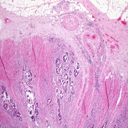

###################################################################
Question:  is colon present?
Predicted Answer:  no
Actual Answer:  yes


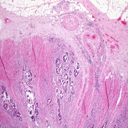

###################################################################
Question:  is edema present?
Predicted Answer:  no
Actual Answer:  no


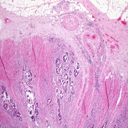

###################################################################
Question:  where is this from?
Predicted Answer:  no
Actual Answer:  gastrointestinal system


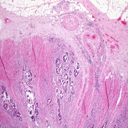

###################################################################
Question:  what is present?
Predicted Answer:  the left ventricle
Actual Answer:  gastrointestinal


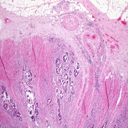

###################################################################
Question:  what is present?
Predicted Answer:  the left ventricle
Actual Answer:  colon


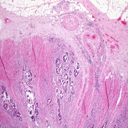

###################################################################
Question:  what does this image show?
Predicted Answer:  with atherosclerosis and thrombotic occlusion
Actual Answer:  typical infiltrating adenocarcinoma


###################################################################
Question:  does this image show typical infiltrating adenocarcinoma?
Predicted Answer:  yes
Actual Answer:  yes


###################################################################
Question:  does retroperitoneal leiomyosarcoma show typical infiltrating adenocarcinoma?
Predicted Answer:  no
Actual Answer:  no


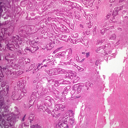

###################################################################
Question:  is endoscopic view of a longitudinally - oriented mallory - weiss characterize d by nests of closely packed glands?
Predicted Answer:  no
Actual Answer:  no


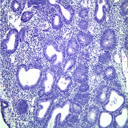

###################################################################
Question:  what is present?
Predicted Answer:  the left ventricle
Actual Answer:  gastrointestinal


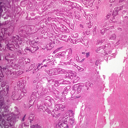

###################################################################
Question:  is gastrointestinal present?
Predicted Answer:  no
Actual Answer:  yes


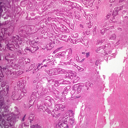

###################################################################
Question:  is adrenal present?
Predicted Answer:  no
Actual Answer:  no


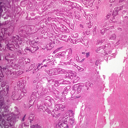

###################################################################
Question:  what is present?
Predicted Answer:  the left ventricle
Actual Answer:  colon


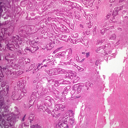

###################################################################
Question:  is colon present?
Predicted Answer:  no
Actual Answer:  yes


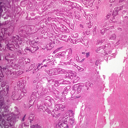

###################################################################
Question:  is coronary artery anomalous origin left from pulmonary artery present?
Predicted Answer:  no
Actual Answer:  no


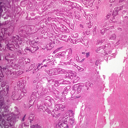

###################################################################
Question:  where is this from?
Predicted Answer:  no
Actual Answer:  gastrointestinal system


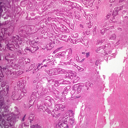

###################################################################
Question:  what is present?
Predicted Answer:  the left ventricle
Actual Answer:  gastrointestinal


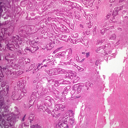

###################################################################
Question:  what is present?
Predicted Answer:  the left ventricle
Actual Answer:  colon


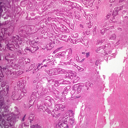

###################################################################
Question:  what does this image show?
Predicted Answer:  with atherosclerosis and thrombotic occlusion
Actual Answer:  typical histology for colon adenocarcinoma


###################################################################
Question:  what is seen as glandular crowding and cellula r atypia?
Predicted Answer:  the left ventricle
Actual Answer:  hyperplasia without atypia


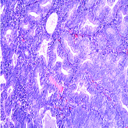

###################################################################
Question:  does this image show typical histology for colon adenocarcinoma?
Predicted Answer:  yes
Actual Answer:  yes


###################################################################
Question:  does amyloid angiopathy r. endocrine show typical histology for colon adenocarcinoma?
Predicted Answer:  no
Actual Answer:  no


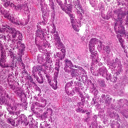

###################################################################
Question:  what is present?
Predicted Answer:  the left ventricle
Actual Answer:  gastrointestinal


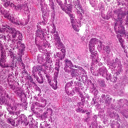

###################################################################
Question:  is gastrointestinal present?
Predicted Answer:  no
Actual Answer:  yes


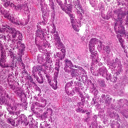

###################################################################
Question:  is alpha smooth muscle actin immunohistochemical present?
Predicted Answer:  no
Actual Answer:  no


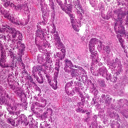

###################################################################
Question:  what is present?
Predicted Answer:  the left ventricle
Actual Answer:  colon


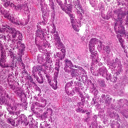

###################################################################
Question:  is colon present?
Predicted Answer:  no
Actual Answer:  yes


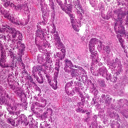

###################################################################
Question:  is lymphangiomatosis present?
Predicted Answer:  no
Actual Answer:  no


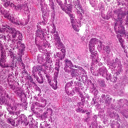

###################################################################
Question:  where is this from?
Predicted Answer:  in vasculature
Actual Answer:  gastrointestinal system


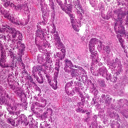

###################################################################
Question:  what is present?
Predicted Answer:  the left ventricle
Actual Answer:  gastrointestinal


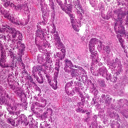

###################################################################
Question:  what is hyperplasia with atypia seen as?
Predicted Answer:  the left ventricle
Actual Answer:  glandular crowding and cellula r atypia


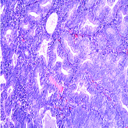

###################################################################
Question:  what is present?
Predicted Answer:  the left ventricle
Actual Answer:  colon


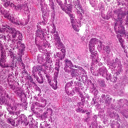

###################################################################
Question:  what does this image show?
Predicted Answer:  with atherosclerosis and thrombotic occlusion
Actual Answer:  typical excellent pinworm


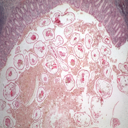

###################################################################
Question:  does this image show typical excellent pinworm?
Predicted Answer:  yes
Actual Answer:  yes


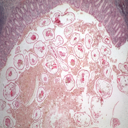

###################################################################
Question:  does acid show typical excellent pinworm?
Predicted Answer:  no
Actual Answer:  no


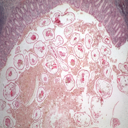

###################################################################
Question:  what is present?
Predicted Answer:  the left ventricle
Actual Answer:  gastrointestinal


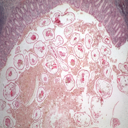

###################################################################
Question:  is gastrointestinal present?
Predicted Answer:  no
Actual Answer:  yes


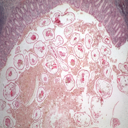

###################################################################
Question:  is myocardium present?
Predicted Answer:  no
Actual Answer:  no


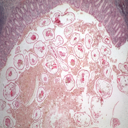

###################################################################
Question:  what is present?
Predicted Answer:  the left ventricle
Actual Answer:  appendix


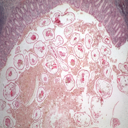

###################################################################
Question:  is appendix present?
Predicted Answer:  no
Actual Answer:  yes


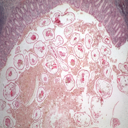

###################################################################
Question:  is carcinoma metastatic lung present?
Predicted Answer:  no
Actual Answer:  no


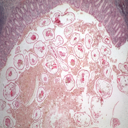

###################################################################
Question:  is hyperplasia with atypia seen as glandular crowding and cellula r atypia?
Predicted Answer:  no
Actual Answer:  yes


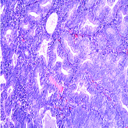

###################################################################
Question:  what is present?
Predicted Answer:  the left ventricle
Actual Answer:  pinworm


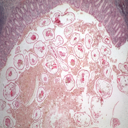

###################################################################
Question:  is pinworm present?
Predicted Answer:  no
Actual Answer:  yes


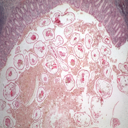

###################################################################
Question:  is normal ovary present?
Predicted Answer:  no
Actual Answer:  no


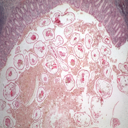

###################################################################
Question:  where is this from?
Predicted Answer:  no
Actual Answer:  gastrointestinal system


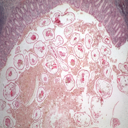

###################################################################
Question:  what is present?
Predicted Answer:  the left ventricle
Actual Answer:  gastrointestinal


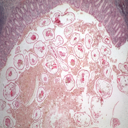

###################################################################
Question:  what is present?
Predicted Answer:  the left ventricle
Actual Answer:  appendix


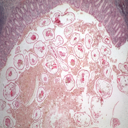

###################################################################
Question:  what is present?
Predicted Answer:  the left ventricle
Actual Answer:  pinworm


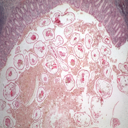

###################################################################
Question:  what does this image show?
Predicted Answer:  with atherosclerosis and thrombotic occlusion
Actual Answer:  trophozoite source


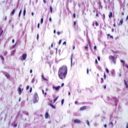

###################################################################
Question:  does this image show trophozoite source?
Predicted Answer:  yes
Actual Answer:  yes


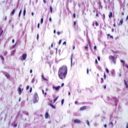

###################################################################
Question:  does glomerulosa show trophozoite source?
Predicted Answer:  no
Actual Answer:  no


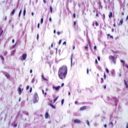

###################################################################
Question:  is a binucleate reed - sternberg cell with large, inclusion - like nucleoli and abundant cytoplasm seen as glandular crowding and cellula r atypia?
Predicted Answer:  no
Actual Answer:  no


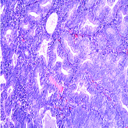

###################################################################
Question:  what is present?
Predicted Answer:  the left ventricle
Actual Answer:  gastrointestinal


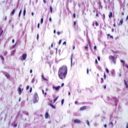

###################################################################
Question:  is gastrointestinal present?
Predicted Answer:  no
Actual Answer:  yes


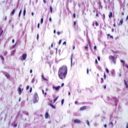

###################################################################
Question:  is metastatic carcinoma prostate present?
Predicted Answer:  no
Actual Answer:  no


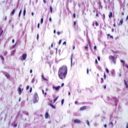

###################################################################
Question:  what is present?
Predicted Answer:  the left ventricle
Actual Answer:  colon


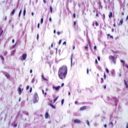

###################################################################
Question:  is colon present?
Predicted Answer:  no
Actual Answer:  yes


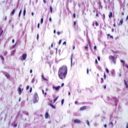

###################################################################
Question:  is appendix present?
Predicted Answer:  no
Actual Answer:  no


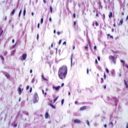

###################################################################
Question:  what is present?
Predicted Answer:  the left ventricle
Actual Answer:  amebiasis


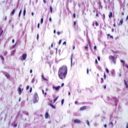

###################################################################
Question:  is amebiasis present?
Predicted Answer:  no
Actual Answer:  yes


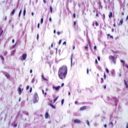

###################################################################
Question:  is lymphangiomatosis present?
Predicted Answer:  no
Actual Answer:  no


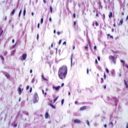

###################################################################
Question:  where is this from?
Predicted Answer:  no
Actual Answer:  gastrointestinal system


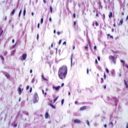

###################################################################
Question:  what shows bundles of normal - looking smooth muscle cel ls?
Predicted Answer:  the left ventricle
Actual Answer:  micros copic appearance of leiomyoma


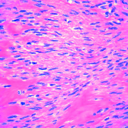

###################################################################
Question:  what is present?
Predicted Answer:  the left ventricle
Actual Answer:  gastrointestinal


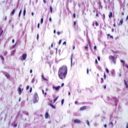

###################################################################
Question:  what is present?
Predicted Answer:  the left ventricle
Actual Answer:  colon


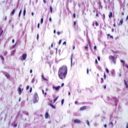

###################################################################
Question:  what is present?
Predicted Answer:  the left ventricle
Actual Answer:  amebiasis


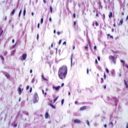

###################################################################
Question:  what does this image show?
Predicted Answer:  with atherosclerosis and thrombotic occlusion
Actual Answer:  inclusion bodies


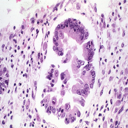

###################################################################
Question:  does this image show inclusion bodies?
Predicted Answer:  yes
Actual Answer:  yes


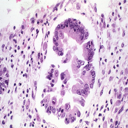

###################################################################
Question:  does atrophy show inclusion bodies?
Predicted Answer:  no
Actual Answer:  no


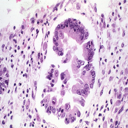

###################################################################
Question:  what is present?
Predicted Answer:  the left ventricle
Actual Answer:  gastrointestinal


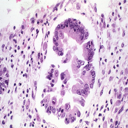

###################################################################
Question:  is gastrointestinal present?
Predicted Answer:  no
Actual Answer:  yes


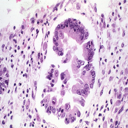

###################################################################
Question:  is antitrypsin present?
Predicted Answer:  no
Actual Answer:  no


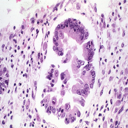

###################################################################
Question:  what is present?
Predicted Answer:  the left ventricle
Actual Answer:  stomach


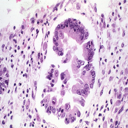

###################################################################
Question:  what does the micros copic appearance of leiomyoma show?
Predicted Answer:  with atherosclerosis and thrombotic occlusion
Actual Answer:  bundles of normal - looking smooth muscle cel ls


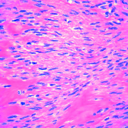

###################################################################
Question:  is stomach present?
Predicted Answer:  no
Actual Answer:  yes


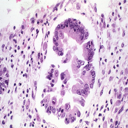

###################################################################
Question:  is cranial artery present?
Predicted Answer:  no
Actual Answer:  no


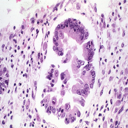

###################################################################
Question:  what is present?
Predicted Answer:  the left ventricle
Actual Answer:  cytomegalovirus


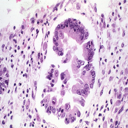

###################################################################
Question:  is cytomegalovirus present?
Predicted Answer:  no
Actual Answer:  yes


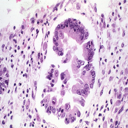

###################################################################
Question:  is acute lymphocytic leukemia present?
Predicted Answer:  no
Actual Answer:  no


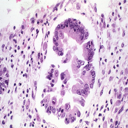

###################################################################
Question:  where is this from?
Predicted Answer:  no
Actual Answer:  gastrointestinal system


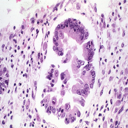

###################################################################
Question:  what is present?
Predicted Answer:  the left ventricle
Actual Answer:  gastrointestinal


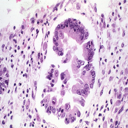

###################################################################


In [32]:
# add batch dimension + move to GPU|
for x in range(100):
    sample = val_vqa_dataset[x]
    print("Question: ",text_processor.decode(sample['input_ids'], skip_special_tokens=True))
    sample = {k: v.unsqueeze(0).to(device) for k,v in sample.items()}

    # forward pass
    outputs = model.generate(pixel_values=sample['pixel_values'],
                            input_ids=sample['input_ids'])
    print("Predicted Answer: ",text_processor.decode(outputs[0][1:],skip_special_tokens=True))
    print("Actual Answer: ",text_processor.decode(sample['labels'][0], skip_special_tokens=True))
    #########################################################################
    unnormalized_image = (sample["pixel_values"][0].cpu().numpy() * np.array(image_std)[:, None, None]) + np.array(image_mean)[:, None, None]
    unnormalized_image = (unnormalized_image * 255).astype(np.uint8)
    unnormalized_image = np.moveaxis(unnormalized_image, 0, -1)
    display(Image.fromarray(unnormalized_image))
    #########################################################################
    print("###################################################################")